# MC para ajuste de modelo a datos experimentales

- Problema: Tenemos pocos datos experimentales como para hacer un buen ajuste de un modelo.

- Solución: Realizamos simulaciones MC de datos sintéticos para estimar: 1) valores promedio de los parámetros para del modelo y 2) los errores de dichos parámetros.

Pasos a seguir:

1) Obtenemos los datos experimentales con sus respectivos errores.

2) Hacemos un ajuste "rápido" de nuestro modelo.

3) Utilizando el ajuste anterior realizamos un número gránde N de simulaciones MC. Cada simulación consistirá en general datos sintéticos que tengan el mismo número de puntos que los datos experimentales.

4) A partir de las N simulaciones obtenemos una distribución de valores de los parámetros del modelo. De aquí podemos obtener un valor medio para cada parámetro, así como su desviación estándar.

In [1]:
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [150]:
# Creamos unos datos "experimentales"
# No hay que hacerle mucho caso

np.random.seed(1323623)

xmin = 0.5
xmax = 3.0
n_data = 10

# Parámetros reales del modelo
# En principio estos valores no los conocemos
a_real =  1.5
b_real = -1.0

x_exp   = np.random.uniform(xmin,xmax,size=n_data)
y_real  = a_real * x_exp**b_real
s_error = 0.1/x_exp
y_exp   = y_real + np.random.normal(scale=s_error,size=np.size(y_real))

<ErrorbarContainer object of 3 artists>

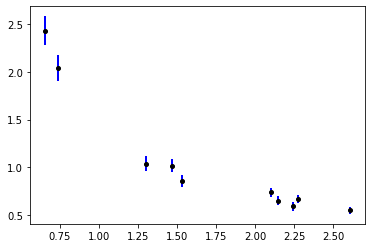

In [151]:
# Graficamos los datos experimentales
plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)

Para saber qué modelo ajustar, necesitamos un buen _prior_

- prior: cualquier cosa que me diga algo sobre lo que estoy observando

Para este ejemplo nuestro _prior_ será suponer que los datos siguen una tendencia que va como
$$
y \propto \frac{1}{x^2}
$$

Entonces el modelo que ajustaremos, siguiendo nuestro _prior_ será:

$$
y(x|a,b) = \frac{a}{x^b}
$$

In [152]:
# Utilizamos nuestro prior y ajustamos el modelo elegido

def power_law(x,a,b):
    return a*x**b

In [153]:
# El prior del prior. Qué parámetros pienso yo que se le ajusta mejor a lo que veo.
vGuess = [1.0,2.0] # Es a ojo 

# Hacemos el ajuste
vParams, aCova = optimize.curve_fit(power_law,x_exp,y_exp,vGuess)
print(vParams)

[ 1.49490637 -1.09745371]


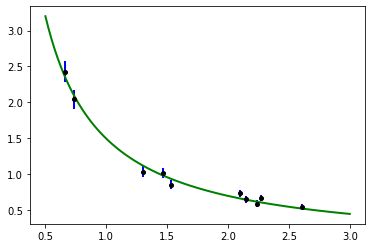

In [154]:
# Plotteamos el ajuste con los datos
x_fine = np.linspace(xmin,xmax,100)
plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)
plt.plot(x_fine,power_law(x_fine,*vParams),"g-",lw=2)

In [155]:
# Creamos simulaciones MC para hacer datos exp. sintéticos.
# Para cada simulación obtendremos un valor de a y b.
# Y finalmente obtendre una distribución para a y b, de la cual
# podemos calcular la desviación estandar y ese sería el error.

n_sim = 50000
FitParams = np.array([])

In [156]:
# Empieza el MC
for i in range(n_sim):
    x_sim = np.random.uniform(0.5,3.0,size=np.size(x_exp)) # ojo, esto es otro prior porque no tiene que ser uniforme
    y_gen = vParams[0]*x_sim**vParams[1] # Agarrar el ajuste anterior y ponerlo como prior de las simulaciones.
    y_sim = y_gen + np.random.normal(scale=s_error,size=np.size(y_gen))
    
    try:
        vsims, acova = optimize.curve_fit(power_law,x_sim,y_sim,vGuess)
    except:
        dumdum=1
        continue # Pasa al siguiente loop
        
    if np.size(FitParams) < 1:
        FitParams = np.copy(vsims)
    else:
        FitParams = np.vstack(( FitParams, vsims ))

In [157]:
np.shape(FitParams)
print(FitParams)

[[ 1.40762695 -0.96835873]
 [ 1.50333612 -1.07459062]
 [ 1.47344147 -1.16180256]
 ...
 [ 1.49922282 -1.02971333]
 [ 1.56853555 -1.07064821]
 [ 1.48852252 -1.03670772]]


In [158]:
# Calcular el valor medio de los parámetros a
print ("Para el parámetro a")
print (np.median(FitParams[:,0]))
print (np.std(FitParams[:,0]))

Para el parámetro a
1.494431045086496
0.05006785903164528


In [159]:
# Calcular el valor medio de los parámetros b
print ("Para el parámetro b")
print (np.median(FitParams[:,1]))
print (np.std(FitParams[:,1]))

Para el parámetro b
-1.097187045473693
0.06605168961026377


In [160]:
med_a = np.median(FitParams[:,0])
std_a = np.std(FitParams[:,0])
med_b = np.median(FitParams[:,1])
std_b = np.std(FitParams[:,1])

Text(0.5, 0, 'Parámetro a')

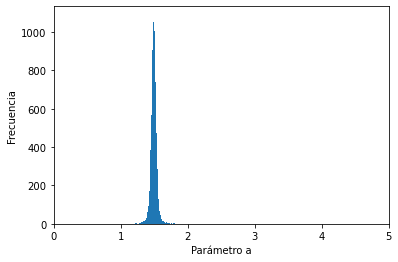

In [161]:
hist_a = pl.hist(FitParams[:,0],bins=1000)
plt.xlim(0,5)
plt.ylabel("Frecuencia")
plt.xlabel("Parámetro a")

Text(0.5, 0, 'Parámetro b')

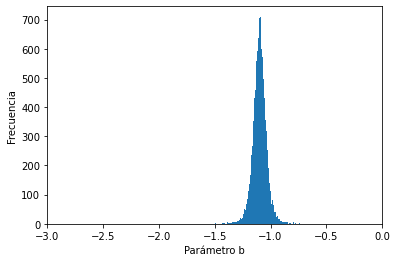

In [162]:
hist_b = pl.hist(FitParams[:,1],bins=1000)
plt.xlim(-3,0)
plt.ylabel("Frecuencia")
plt.xlabel("Parámetro b")

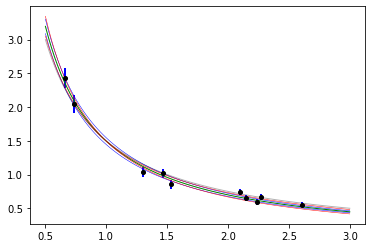

In [163]:
x_fine = np.linspace(xmin,xmax,100)
plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)
pl.plot(x_fine,power_law(x_fine,med_a,med_b),"g-",lw=1)
pl.plot(x_fine,power_law(x_fine,med_a + std_a,med_b),"b-",lw=0.5)
pl.plot(x_fine,power_law(x_fine,med_a - std_a,med_b),"b-",lw=0.5)
pl.plot(x_fine,power_law(x_fine,med_a,med_b + std_b),"r-",lw=0.5)
pl.plot(x_fine,power_law(x_fine,med_a,med_b - std_b),"r-",lw=0.5)
pl.plot(x_fine,power_law(x_fine,a_real,b_real),"k-",lw=1,alpha=0.3)